STUDENTS:
Julio Renaldi De Castro - 101295616
Safa Aru - 101331910
Ahmet Buyukbas - 101304595
Onur Korkmaz - 101303363

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify training data directory
XRay_Directory = '/content/drive/MyDrive/Chest_X_Ray/train'

In [ ]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '3', '2']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory=XRay_Directory,
                                                      shuffle=True,
                                                      target_size=(256, 256),
                                                      class_mode = 'categorical',
                                                      subset = 'training')

Found 436 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")


Found 106 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
!pip install pillow
train_images, train_labels = next(train_generator)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]],

In [ ]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

In [ ]:
print(train_images.shape)
print(train_labels.shape)

(40, 256, 256, 3)
(40, 4)


Data Visualization

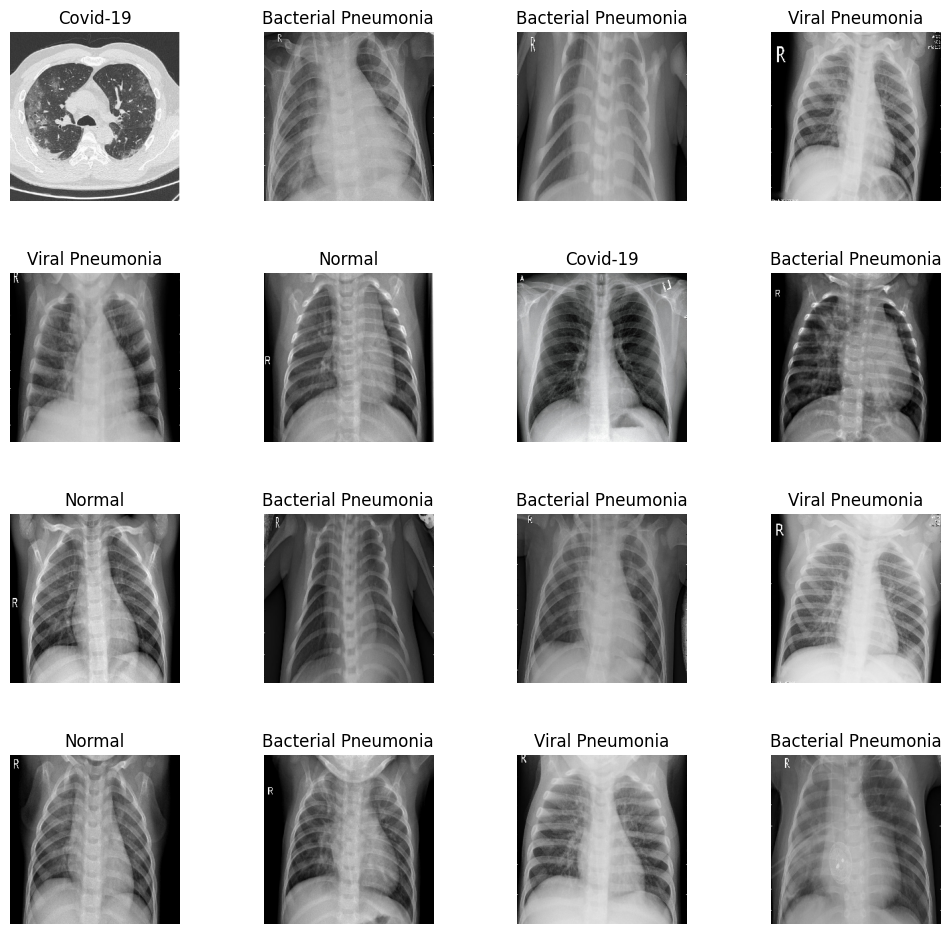

In [ ]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

  plt.subplots_adjust(wspace = 0.5)    

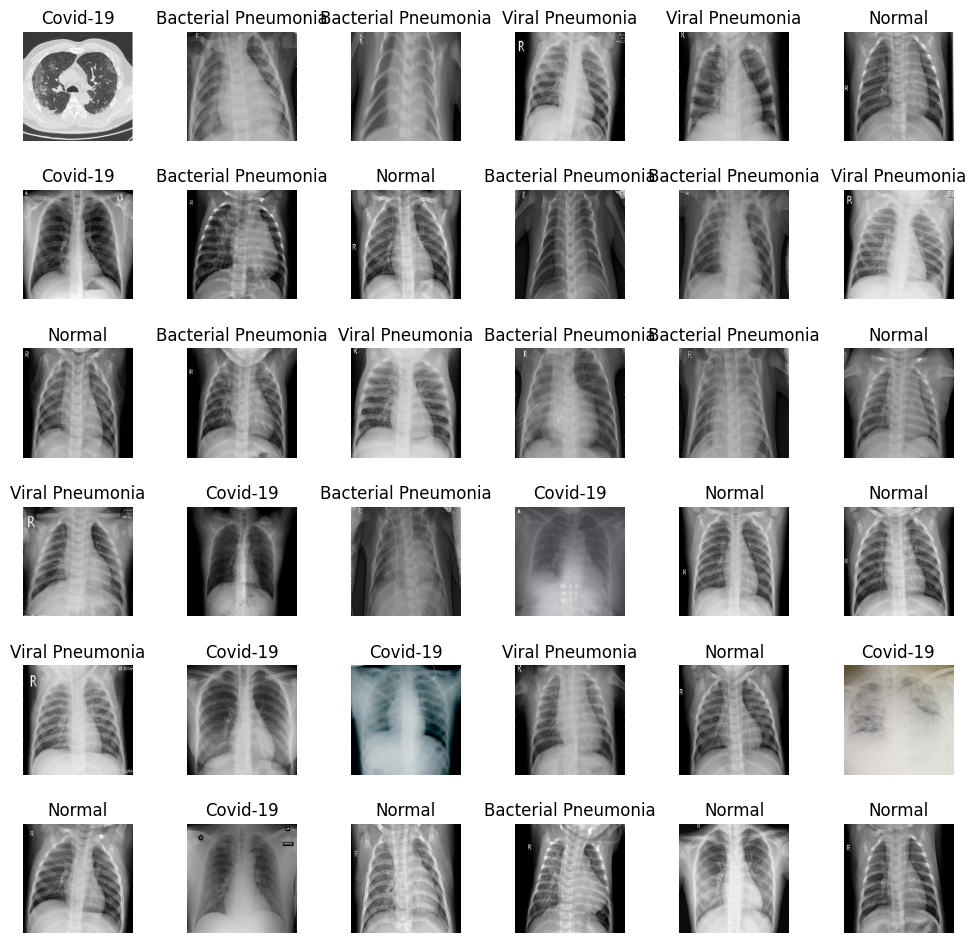

In [ ]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)   

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top=False, input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)

headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
from tensorflow.keras.optimizers import legacy

model.compile(loss = 'categorical_crossentropy', 
              optimizer = legacy.RMSprop(learning_rate=1e-4, decay=1e-6), 
              metrics= ["accuracy"])


In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
# checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

from tensorflow.keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/savedWeights/weights.hdf5"
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)


In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 436 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 3, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/3
109/109 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.6881
Epoch 1: val_loss improved from inf to 7.39552, saving model to /content/drive/MyDrive/savedWeights/weights.hdf5
109/109 [==============================] - 38s 211ms/step - loss: 0.8690 - accuracy: 0.6881 - val_loss: 7.3955 - val_accuracy: 0.2500
Epoch 2/3
109/109 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8486
Epoch 2: val_loss did not improve from 7.39552
109/109 [==============================] - 17s 155ms/step - loss: 0.4020 - accuracy: 0.8486 - val_loss: 23.5772 - val_accuracy: 0.2404
Epoch 3/3
109/109 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.9014
Epoch 3: val_loss did not improve from 7.39552
109/109 [==============================] - 16s 150ms/step - loss: 0.3471 - accuracy: 0.9014 - val_loss: 35.1929 - val_accuracy: 0.2500


In [ ]:
# serialize model to JSON
from tensorflow.keras.models import model_from_json
import json

# Convert the model to JSON format
model_json = model.to_json()

# Save the model JSON to a file
with open('/content/drive/MyDrive/savedWeights/model.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
# Save the model weights to a file
model.save_weights('/content/drive/MyDrive/savedWeights/model.h5')
print("Saved model weights to disk")


Saved model weights to disk


In [ ]:
# load json and create model

from tensorflow.keras.models import model_from_json
import json

# Load the model architecture from a JSON file
with open('/content/drive/MyDrive/savedWeights/model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Create a new model from the loaded architecture
model = model_from_json(loaded_model_json)

# load weights into new model
# Load the model weights from a file
model.load_weights('/content/drive/MyDrive/savedWeights/chestdisease_trained_model.h5')
print("Loaded model weights from disk")


Loaded model weights from disk


In [ ]:
# Let's compile the model 
# model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', 
              optimizer = legacy.RMSprop(learning_rate=1e-4, decay=1e-6), 
              metrics= ["accuracy"])

In [ ]:
test_directory = '/content/drive/MyDrive/Chest_X_Ray/Test'


In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


<ipython-input-116-15440cd26711>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


 1/10 [==>...........................] - ETA: 24s - loss: 2.4291 - accuracy: 0.8000

10/10 [==============================] - 3s 5ms/step - loss: 2.4291 - accuracy: 0.8000
Accuracy Test : 0.800000011920929


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(4):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)


1/1 [==============================] - 0s 29ms/step


In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


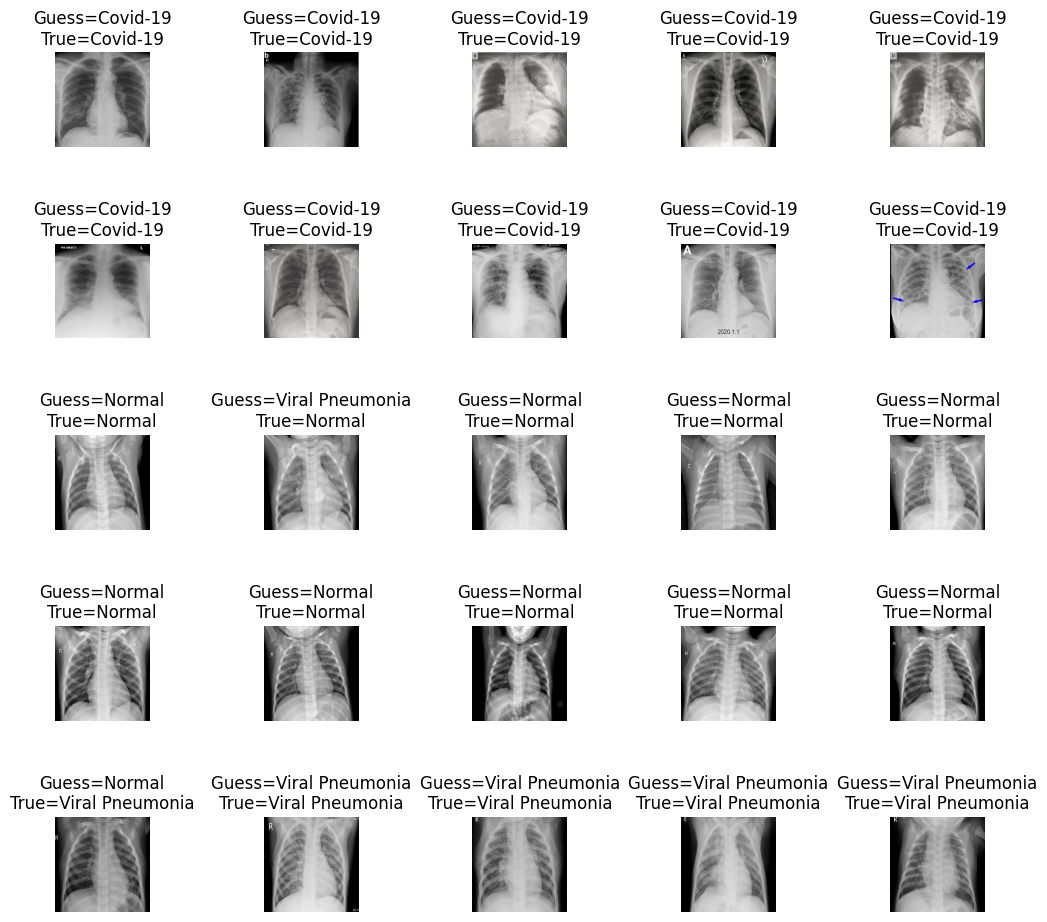

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.82      0.90      0.86        10
           2       0.67      0.60      0.63        10
           3       0.86      0.60      0.71        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



Text(0.5, 1.0, 'Confusion_matrix')

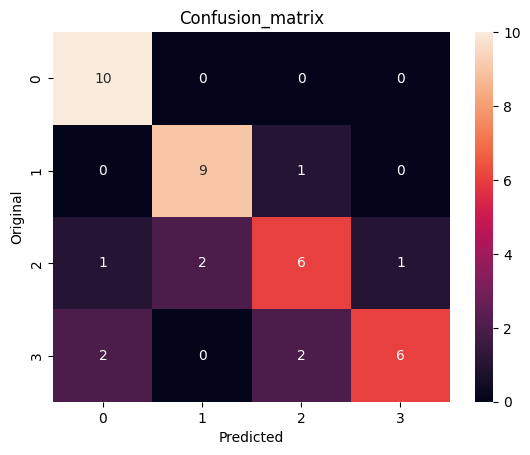

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')